# Improved balance data


c:\Users\Kuanr\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


data shape: (44505, 3, 200, 200) | target shape: (44505, 1, 200, 200)


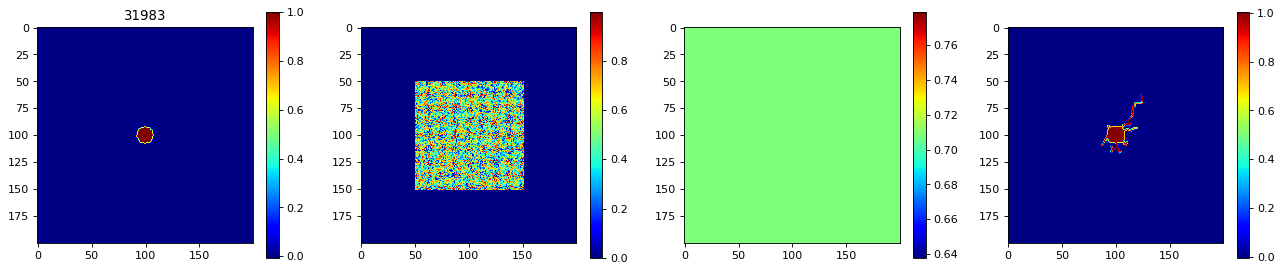

In [1]:
import numpy as np
from dataset import H5Dataset
import matplotlib.pyplot as plt

dataset = H5Dataset('../dataset_for_ML/NG_single_CNN_restructured_11022022.hdf5')

x = dataset.data
y = dataset.target
print(f'data shape: {x.shape} | target shape: {y.shape}')

for i in range(1):
    id = np.random.randint(x.shape[0])
    plt.figure(figsize=(20, 4), dpi=80)
    plt.subplot(1,4,1)
    plt.imshow(x[id,0,...],cmap = "jet")
    plt.title(id)
    plt.colorbar()
    plt.subplot(1,4,2)
    plt.imshow(x[id,1,...],cmap = "jet")
    plt.colorbar()
    plt.subplot(1,4,3)
    plt.imshow(x[id,2,...],cmap = "jet")
    plt.colorbar()
    plt.subplot(1,4,4)
    plt.imshow(y[id,0,...],cmap = "jet")
    plt.colorbar()
    

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np
import data
from dataset import rdDataset_old
from dataset import H5Dataset
from model import rdcnn_2_larger
from math import log10

from tqdm import tqdm

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
# cudnn.benchmark = True
path = './data'

# Parameters

params = {'test_split': .25,
          'shuffle_dataset': True,
          'batchsize': 64,
          'testBatchsize': 64,
          'random_seed': 42,
          'numworkers':0,
          'pinmemory':True}
    
max_epoches = 100
learning_rate = 1e-4
drop_rate = 0.0

print('===> Loading datasets')
# Load All Dataset

# Creating data indices for training and validation splits:
training_data_loader, testing_data_loader = data.DatasetSplit(dataset, **params)

print('===> Building model')
model = rdcnn_2_larger(drop_rate).to(device)
# criterion = nn.MSELoss()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-5)

m = nn.Sigmoid()

def train(epoch):
    epoch_loss = 0
    for iteration, batch in enumerate(tqdm(training_data_loader), 1):
        input, target = batch[0].to(device, torch.float), batch[1].to(device, torch.float)
        optimizer.zero_grad()
        loss = criterion(model(input), target)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(training_data_loader)))
    return epoch, epoch_loss / len(training_data_loader)
    
def test():
    avg_error = 0
    avg_loss = 0
    with torch.no_grad():
        for batch in tqdm(testing_data_loader):
            input, target = batch[0].to(device, torch.float), batch[1].to(device, torch.float)

            prediction = model(input)
            tmp_error = 0
            for j in range(len(prediction)):
                tmp_error += torch.sqrt(torch.mean((m(prediction[j])-target[j])**2))/torch.max(target[j])
            avg_error += tmp_error / len(prediction)
            mse = criterion(prediction, target)
            avg_loss += mse
    print("===> Avg. Loss: {:.4f} ".format(avg_loss / len(testing_data_loader)))
    print("===> Avg. Error: {:.4f} ".format(avg_error / len(testing_data_loader)))
    return avg_loss / len(testing_data_loader),avg_error / len(testing_data_loader)

def checkpoint(epoch):
    model_out_path = "./checkpoint_3channel_singleNeuron_BCE/model_epoch_{}.pth".format(epoch)
    torch.save(model, model_out_path)
    print("Checkpoint saved to {}".format(model_out_path))
    
model.eval()  

===> Loading datasets
===> Building model


rdcnn_2_larger(
  (encoder): Sequential(
    (0): Conv2d(3, 84, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.0, inplace=False)
    (4): Conv2d(84, 168, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(168, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Dropout(p=0.0, inplace=False)
    (8): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(168, 336, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(336, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Dropout(p=0.0, inplace=False)
    (13): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(p=0.0, inplace=False)
  )
  (decoder): Sequential(
    (0): ConvTranspos

In [3]:
L_train_loss = []
L_test_loss = []
L_test_error = []
for epoch in range(1, max_epoches + 1):
    train_loss = train(epoch)
    test_loss,test_error = test()
    checkpoint(epoch)
    L_train_loss.append(train_loss)
    L_test_loss.append(test_loss)
    L_test_error.append(test_error)
    print(f'###############################################################')

100%|██████████| 522/522 [07:38<00:00,  1.14it/s]


===> Epoch 1 Complete: Avg. Loss: 0.0265


100%|██████████| 174/174 [00:57<00:00,  3.05it/s]


===> Avg. Loss: 0.0123 
===> Avg. Error: 0.0519 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_1.pth
###############################################################


100%|██████████| 522/522 [07:40<00:00,  1.13it/s]


===> Epoch 2 Complete: Avg. Loss: 0.0123


100%|██████████| 174/174 [00:57<00:00,  3.04it/s]


===> Avg. Loss: 0.0118 
===> Avg. Error: 0.0513 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_2.pth
###############################################################


100%|██████████| 522/522 [07:39<00:00,  1.14it/s]


===> Epoch 3 Complete: Avg. Loss: 0.0120


100%|██████████| 174/174 [00:57<00:00,  3.05it/s]


===> Avg. Loss: 0.0135 
===> Avg. Error: 0.0551 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_3.pth
###############################################################


100%|██████████| 522/522 [07:39<00:00,  1.14it/s]


===> Epoch 4 Complete: Avg. Loss: 0.0105


100%|██████████| 174/174 [00:57<00:00,  3.03it/s]


===> Avg. Loss: 0.0092 
===> Avg. Error: 0.0485 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_4.pth
###############################################################


100%|██████████| 522/522 [07:40<00:00,  1.13it/s]


===> Epoch 5 Complete: Avg. Loss: 0.0087


100%|██████████| 174/174 [00:57<00:00,  3.04it/s]


===> Avg. Loss: 0.0084 
===> Avg. Error: 0.0473 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_5.pth
###############################################################


100%|██████████| 522/522 [07:40<00:00,  1.13it/s]


===> Epoch 6 Complete: Avg. Loss: 0.0082


100%|██████████| 174/174 [00:57<00:00,  3.04it/s]


===> Avg. Loss: 0.0080 
===> Avg. Error: 0.0464 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_6.pth
###############################################################


100%|██████████| 522/522 [07:40<00:00,  1.13it/s]


===> Epoch 7 Complete: Avg. Loss: 0.0079


100%|██████████| 174/174 [00:57<00:00,  3.04it/s]


===> Avg. Loss: 0.0076 
===> Avg. Error: 0.0455 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_7.pth
###############################################################


100%|██████████| 522/522 [07:40<00:00,  1.13it/s]


===> Epoch 8 Complete: Avg. Loss: 0.0075


100%|██████████| 174/174 [00:57<00:00,  3.03it/s]


===> Avg. Loss: 0.0074 
===> Avg. Error: 0.0448 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_8.pth
###############################################################


100%|██████████| 522/522 [07:40<00:00,  1.13it/s]


===> Epoch 9 Complete: Avg. Loss: 0.0071


100%|██████████| 174/174 [00:57<00:00,  3.04it/s]


===> Avg. Loss: 0.0068 
===> Avg. Error: 0.0429 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_9.pth
###############################################################


100%|██████████| 522/522 [07:40<00:00,  1.13it/s]


===> Epoch 10 Complete: Avg. Loss: 0.0066


100%|██████████| 174/174 [00:57<00:00,  3.04it/s]


===> Avg. Loss: 0.0064 
===> Avg. Error: 0.0415 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_10.pth
###############################################################


100%|██████████| 522/522 [07:40<00:00,  1.13it/s]


===> Epoch 11 Complete: Avg. Loss: 0.0060


100%|██████████| 174/174 [00:57<00:00,  3.03it/s]


===> Avg. Loss: 0.0056 
===> Avg. Error: 0.0392 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_11.pth
###############################################################


100%|██████████| 522/522 [07:41<00:00,  1.13it/s]


===> Epoch 12 Complete: Avg. Loss: 0.0053


100%|██████████| 174/174 [00:57<00:00,  3.04it/s]


===> Avg. Loss: 0.0050 
===> Avg. Error: 0.0367 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_12.pth
###############################################################


100%|██████████| 522/522 [07:40<00:00,  1.13it/s]


===> Epoch 13 Complete: Avg. Loss: 0.0049


100%|██████████| 174/174 [00:57<00:00,  3.04it/s]


===> Avg. Loss: 0.0046 
===> Avg. Error: 0.0351 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_13.pth
###############################################################


100%|██████████| 522/522 [07:41<00:00,  1.13it/s]


===> Epoch 14 Complete: Avg. Loss: 0.0046


100%|██████████| 174/174 [00:57<00:00,  3.04it/s]


===> Avg. Loss: 0.0043 
===> Avg. Error: 0.0337 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_14.pth
###############################################################


100%|██████████| 522/522 [07:41<00:00,  1.13it/s]


===> Epoch 15 Complete: Avg. Loss: 0.0043


100%|██████████| 174/174 [00:57<00:00,  3.04it/s]


===> Avg. Loss: 0.0042 
===> Avg. Error: 0.0332 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_15.pth
###############################################################


100%|██████████| 522/522 [07:40<00:00,  1.13it/s]


===> Epoch 16 Complete: Avg. Loss: 0.0041


100%|██████████| 174/174 [00:57<00:00,  3.04it/s]


===> Avg. Loss: 0.0041 
===> Avg. Error: 0.0325 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_16.pth
###############################################################


100%|██████████| 522/522 [07:40<00:00,  1.13it/s]


===> Epoch 17 Complete: Avg. Loss: 0.0040


100%|██████████| 174/174 [00:57<00:00,  3.04it/s]


===> Avg. Loss: 0.0038 
===> Avg. Error: 0.0311 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_17.pth
###############################################################


100%|██████████| 522/522 [07:41<00:00,  1.13it/s]


===> Epoch 18 Complete: Avg. Loss: 0.0038


100%|██████████| 174/174 [00:57<00:00,  3.05it/s]


===> Avg. Loss: 0.0037 
===> Avg. Error: 0.0304 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_18.pth
###############################################################


100%|██████████| 522/522 [07:40<00:00,  1.13it/s]


===> Epoch 19 Complete: Avg. Loss: 0.0037


100%|██████████| 174/174 [00:57<00:00,  3.04it/s]


===> Avg. Loss: 0.0037 
===> Avg. Error: 0.0305 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_19.pth
###############################################################


100%|██████████| 522/522 [07:41<00:00,  1.13it/s]


===> Epoch 20 Complete: Avg. Loss: 0.0036


100%|██████████| 174/174 [00:57<00:00,  3.04it/s]


===> Avg. Loss: 0.0035 
===> Avg. Error: 0.0294 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_20.pth
###############################################################


100%|██████████| 522/522 [07:40<00:00,  1.13it/s]


===> Epoch 21 Complete: Avg. Loss: 0.0035


100%|██████████| 174/174 [00:57<00:00,  3.04it/s]


===> Avg. Loss: 0.0034 
===> Avg. Error: 0.0288 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_21.pth
###############################################################


100%|██████████| 522/522 [07:41<00:00,  1.13it/s]


===> Epoch 22 Complete: Avg. Loss: 0.0034


100%|██████████| 174/174 [00:57<00:00,  3.04it/s]


===> Avg. Loss: 0.0034 
===> Avg. Error: 0.0293 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_22.pth
###############################################################


100%|██████████| 522/522 [07:41<00:00,  1.13it/s]


===> Epoch 23 Complete: Avg. Loss: 0.0033


100%|██████████| 174/174 [00:57<00:00,  3.04it/s]


===> Avg. Loss: 0.0032 
===> Avg. Error: 0.0280 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_23.pth
###############################################################


100%|██████████| 522/522 [07:41<00:00,  1.13it/s]


===> Epoch 24 Complete: Avg. Loss: 0.0032


100%|██████████| 174/174 [00:57<00:00,  3.04it/s]


===> Avg. Loss: 0.0031 
===> Avg. Error: 0.0274 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_24.pth
###############################################################


100%|██████████| 522/522 [07:41<00:00,  1.13it/s]


===> Epoch 25 Complete: Avg. Loss: 0.0031


100%|██████████| 174/174 [00:57<00:00,  3.03it/s]


===> Avg. Loss: 0.0031 
===> Avg. Error: 0.0274 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_25.pth
###############################################################


100%|██████████| 522/522 [07:41<00:00,  1.13it/s]


===> Epoch 26 Complete: Avg. Loss: 0.0030


100%|██████████| 174/174 [00:57<00:00,  3.03it/s]


===> Avg. Loss: 0.0030 
===> Avg. Error: 0.0268 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_26.pth
###############################################################


100%|██████████| 522/522 [07:41<00:00,  1.13it/s]


===> Epoch 27 Complete: Avg. Loss: 0.0030


100%|██████████| 174/174 [00:57<00:00,  3.04it/s]


===> Avg. Loss: 0.0031 
===> Avg. Error: 0.0279 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_27.pth
###############################################################


100%|██████████| 522/522 [07:41<00:00,  1.13it/s]


===> Epoch 28 Complete: Avg. Loss: 0.0029


100%|██████████| 174/174 [00:57<00:00,  3.04it/s]


===> Avg. Loss: 0.0027 
===> Avg. Error: 0.0253 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_28.pth
###############################################################


100%|██████████| 522/522 [07:41<00:00,  1.13it/s]


===> Epoch 29 Complete: Avg. Loss: 0.0028


100%|██████████| 174/174 [00:57<00:00,  3.03it/s]


===> Avg. Loss: 0.0028 
===> Avg. Error: 0.0256 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_29.pth
###############################################################


100%|██████████| 522/522 [07:40<00:00,  1.13it/s]


===> Epoch 30 Complete: Avg. Loss: 0.0027


100%|██████████| 174/174 [00:57<00:00,  3.04it/s]


===> Avg. Loss: 0.0027 
===> Avg. Error: 0.0249 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_30.pth
###############################################################


100%|██████████| 522/522 [07:40<00:00,  1.13it/s]


===> Epoch 31 Complete: Avg. Loss: 0.0026


100%|██████████| 174/174 [00:57<00:00,  3.04it/s]


===> Avg. Loss: 0.0026 
===> Avg. Error: 0.0249 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_31.pth
###############################################################


100%|██████████| 522/522 [07:40<00:00,  1.13it/s]


===> Epoch 32 Complete: Avg. Loss: 0.0025


100%|██████████| 174/174 [00:57<00:00,  3.03it/s]


===> Avg. Loss: 0.0025 
===> Avg. Error: 0.0238 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_32.pth
###############################################################


100%|██████████| 522/522 [07:40<00:00,  1.13it/s]


===> Epoch 33 Complete: Avg. Loss: 0.0025


100%|██████████| 174/174 [00:57<00:00,  3.04it/s]


===> Avg. Loss: 0.0025 
===> Avg. Error: 0.0235 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_33.pth
###############################################################


100%|██████████| 522/522 [07:40<00:00,  1.13it/s]


===> Epoch 34 Complete: Avg. Loss: 0.0024


100%|██████████| 174/174 [00:57<00:00,  3.04it/s]


===> Avg. Loss: 0.0025 
===> Avg. Error: 0.0237 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_34.pth
###############################################################


100%|██████████| 522/522 [07:41<00:00,  1.13it/s]


===> Epoch 35 Complete: Avg. Loss: 0.0023


100%|██████████| 174/174 [00:57<00:00,  3.03it/s]


===> Avg. Loss: 0.0029 
===> Avg. Error: 0.0267 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_35.pth
###############################################################


100%|██████████| 522/522 [07:40<00:00,  1.13it/s]


===> Epoch 36 Complete: Avg. Loss: 0.0023


100%|██████████| 174/174 [00:57<00:00,  3.04it/s]


===> Avg. Loss: 0.0022 
===> Avg. Error: 0.0220 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_36.pth
###############################################################


100%|██████████| 522/522 [07:40<00:00,  1.13it/s]


===> Epoch 37 Complete: Avg. Loss: 0.0022


100%|██████████| 174/174 [00:57<00:00,  3.04it/s]


===> Avg. Loss: 0.0022 
===> Avg. Error: 0.0218 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_37.pth
###############################################################


100%|██████████| 522/522 [07:40<00:00,  1.13it/s]


===> Epoch 38 Complete: Avg. Loss: 0.0022


100%|██████████| 174/174 [00:57<00:00,  3.04it/s]


===> Avg. Loss: 0.0022 
===> Avg. Error: 0.0217 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_38.pth
###############################################################


100%|██████████| 522/522 [07:40<00:00,  1.13it/s]


===> Epoch 39 Complete: Avg. Loss: 0.0021


100%|██████████| 174/174 [00:57<00:00,  3.04it/s]


===> Avg. Loss: 0.0021 
===> Avg. Error: 0.0212 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_39.pth
###############################################################


100%|██████████| 522/522 [07:39<00:00,  1.14it/s]


===> Epoch 40 Complete: Avg. Loss: 0.0021


100%|██████████| 174/174 [00:57<00:00,  3.04it/s]


===> Avg. Loss: 0.0020 
===> Avg. Error: 0.0209 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_40.pth
###############################################################


100%|██████████| 522/522 [07:39<00:00,  1.14it/s]


===> Epoch 41 Complete: Avg. Loss: 0.0020


100%|██████████| 174/174 [00:57<00:00,  3.05it/s]


===> Avg. Loss: 0.0020 
===> Avg. Error: 0.0202 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_41.pth
###############################################################


100%|██████████| 522/522 [07:38<00:00,  1.14it/s]


===> Epoch 42 Complete: Avg. Loss: 0.0020


100%|██████████| 174/174 [00:57<00:00,  3.05it/s]


===> Avg. Loss: 0.0020 
===> Avg. Error: 0.0207 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_42.pth
###############################################################


100%|██████████| 522/522 [07:38<00:00,  1.14it/s]


===> Epoch 43 Complete: Avg. Loss: 0.0019


100%|██████████| 174/174 [00:57<00:00,  3.05it/s]


===> Avg. Loss: 0.0019 
===> Avg. Error: 0.0201 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_43.pth
###############################################################


100%|██████████| 522/522 [07:38<00:00,  1.14it/s]


===> Epoch 44 Complete: Avg. Loss: 0.0019


100%|██████████| 174/174 [00:56<00:00,  3.06it/s]


===> Avg. Loss: 0.0018 
===> Avg. Error: 0.0194 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_44.pth
###############################################################


100%|██████████| 522/522 [07:37<00:00,  1.14it/s]


===> Epoch 45 Complete: Avg. Loss: 0.0018


100%|██████████| 174/174 [00:56<00:00,  3.06it/s]


===> Avg. Loss: 0.0019 
===> Avg. Error: 0.0197 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_45.pth
###############################################################


100%|██████████| 522/522 [07:37<00:00,  1.14it/s]


===> Epoch 46 Complete: Avg. Loss: 0.0018


100%|██████████| 174/174 [00:56<00:00,  3.06it/s]


===> Avg. Loss: 0.0018 
===> Avg. Error: 0.0190 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_46.pth
###############################################################


100%|██████████| 522/522 [07:37<00:00,  1.14it/s]


===> Epoch 47 Complete: Avg. Loss: 0.0018


100%|██████████| 174/174 [00:56<00:00,  3.07it/s]


===> Avg. Loss: 0.0018 
===> Avg. Error: 0.0193 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_47.pth
###############################################################


100%|██████████| 522/522 [07:37<00:00,  1.14it/s]


===> Epoch 48 Complete: Avg. Loss: 0.0017


100%|██████████| 174/174 [00:56<00:00,  3.07it/s]


===> Avg. Loss: 0.0017 
===> Avg. Error: 0.0184 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_48.pth
###############################################################


100%|██████████| 522/522 [07:37<00:00,  1.14it/s]


===> Epoch 49 Complete: Avg. Loss: 0.0017


100%|██████████| 174/174 [00:56<00:00,  3.07it/s]


===> Avg. Loss: 0.0018 
===> Avg. Error: 0.0188 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_49.pth
###############################################################


100%|██████████| 522/522 [07:37<00:00,  1.14it/s]


===> Epoch 50 Complete: Avg. Loss: 0.0017


100%|██████████| 174/174 [00:56<00:00,  3.07it/s]


===> Avg. Loss: 0.0017 
===> Avg. Error: 0.0184 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_50.pth
###############################################################


100%|██████████| 522/522 [07:37<00:00,  1.14it/s]


===> Epoch 51 Complete: Avg. Loss: 0.0016


100%|██████████| 174/174 [00:56<00:00,  3.07it/s]


===> Avg. Loss: 0.0017 
===> Avg. Error: 0.0183 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_51.pth
###############################################################


100%|██████████| 522/522 [07:36<00:00,  1.14it/s]


===> Epoch 52 Complete: Avg. Loss: 0.0016


100%|██████████| 174/174 [00:56<00:00,  3.07it/s]


===> Avg. Loss: 0.0016 
===> Avg. Error: 0.0176 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_52.pth
###############################################################


100%|██████████| 522/522 [07:37<00:00,  1.14it/s]


===> Epoch 53 Complete: Avg. Loss: 0.0016


100%|██████████| 174/174 [00:56<00:00,  3.07it/s]


===> Avg. Loss: 0.0017 
===> Avg. Error: 0.0182 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_53.pth
###############################################################


100%|██████████| 522/522 [07:36<00:00,  1.14it/s]


===> Epoch 54 Complete: Avg. Loss: 0.0016


100%|██████████| 174/174 [00:56<00:00,  3.08it/s]


===> Avg. Loss: 0.0016 
===> Avg. Error: 0.0172 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_54.pth
###############################################################


100%|██████████| 522/522 [07:36<00:00,  1.14it/s]


===> Epoch 55 Complete: Avg. Loss: 0.0015


100%|██████████| 174/174 [00:56<00:00,  3.07it/s]


===> Avg. Loss: 0.0016 
===> Avg. Error: 0.0176 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_55.pth
###############################################################


100%|██████████| 522/522 [07:35<00:00,  1.15it/s]


===> Epoch 56 Complete: Avg. Loss: 0.0015


100%|██████████| 174/174 [00:56<00:00,  3.08it/s]


===> Avg. Loss: 0.0015 
===> Avg. Error: 0.0170 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_56.pth
###############################################################


100%|██████████| 522/522 [07:35<00:00,  1.15it/s]


===> Epoch 57 Complete: Avg. Loss: 0.0015


100%|██████████| 174/174 [00:56<00:00,  3.09it/s]


===> Avg. Loss: 0.0015 
===> Avg. Error: 0.0169 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_57.pth
###############################################################


100%|██████████| 522/522 [07:34<00:00,  1.15it/s]


===> Epoch 58 Complete: Avg. Loss: 0.0015


100%|██████████| 174/174 [00:56<00:00,  3.09it/s]


===> Avg. Loss: 0.0015 
===> Avg. Error: 0.0168 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_58.pth
###############################################################


100%|██████████| 522/522 [07:34<00:00,  1.15it/s]


===> Epoch 59 Complete: Avg. Loss: 0.0015


100%|██████████| 174/174 [00:56<00:00,  3.08it/s]


===> Avg. Loss: 0.0016 
===> Avg. Error: 0.0172 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_59.pth
###############################################################


100%|██████████| 522/522 [07:34<00:00,  1.15it/s]


===> Epoch 60 Complete: Avg. Loss: 0.0015


100%|██████████| 174/174 [00:56<00:00,  3.08it/s]


===> Avg. Loss: 0.0015 
===> Avg. Error: 0.0167 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_60.pth
###############################################################


100%|██████████| 522/522 [07:33<00:00,  1.15it/s]


===> Epoch 61 Complete: Avg. Loss: 0.0014


100%|██████████| 174/174 [00:56<00:00,  3.09it/s]


===> Avg. Loss: 0.0016 
===> Avg. Error: 0.0171 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_61.pth
###############################################################


100%|██████████| 522/522 [07:33<00:00,  1.15it/s]


===> Epoch 62 Complete: Avg. Loss: 0.0014


100%|██████████| 174/174 [00:56<00:00,  3.09it/s]


===> Avg. Loss: 0.0015 
===> Avg. Error: 0.0171 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_62.pth
###############################################################


100%|██████████| 522/522 [07:34<00:00,  1.15it/s]


===> Epoch 63 Complete: Avg. Loss: 0.0014


100%|██████████| 174/174 [00:56<00:00,  3.08it/s]


===> Avg. Loss: 0.0014 
===> Avg. Error: 0.0160 
Checkpoint saved to ./checkpoint_3channel_singleNeuron_BCE/model_epoch_63.pth
###############################################################


 75%|███████▍  | 390/522 [05:38<01:54,  1.15it/s]

In [ ]:
# model = torch.load('./checkpoint_3channel_singleNeuron/model_epoch_100.pth')
# model.eval()

In [ ]:
import data
import importlib 
importlib.reload(data)
data.TestErrorPlot(model,device, testing_data_loader)

In [ ]:
from matplotlib import pyplot as plt
prediction_L = []
input_L = []
target_L = []
i=0

with torch.no_grad():
    for batch in testing_data_loader:
        input, target = batch[0].to(device, torch.float), batch[1].to(device, torch.float)
        input_L.append(input)
        target_L.append(target)
        prediction = m(model(input))
        # prediction = model(input)
        prediction_L.append(prediction)
        i = i+1
        if i==10:
            break

In [ ]:
for i in range(1):
    input = input_L[i].cpu().numpy()
    target = target_L[i]
    fig, ax = plt.subplots(1,5, figsize=(20,5))
    for t in range(5):
        im = ax[t].imshow(target[t][0].cpu(),cmap = "jet")
        ax[t].axis('off')
        # ax[t].set_title("iteration = "+str(input[t,2,0,0]),size=10)

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.84, 0.27, 0.01, 0.47])
    fig.colorbar(im, cax=cbar_ax)
    
    fig, ax = plt.subplots(1,5, figsize=(20,5))
    for t in range(5,10):
        im = ax[t-5].imshow(target[t][0].cpu(),cmap = "jet")
        ax[t-5].axis('off')
        # ax[t-5].set_title("iteration = "+str(input[t,2,0,0]),size=10)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.84, 0.27, 0.01, 0.47])
    fig.colorbar(im, cax=cbar_ax)


plt.show()

In [ ]:
for i in range(1):
    input = input_L[i].cpu().numpy()
    prediction = prediction_L[i]
    fig, ax = plt.subplots(1,5, figsize=(20,5))
    for t in range(5):
        im = ax[t].imshow(prediction[t][0].cpu(),cmap = "jet")
        ax[t].axis('off')
        # ax[t].set_title("iteration = "+str(input[t,2,0,0]),size=10)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.84, 0.27, 0.01, 0.47])
    fig.colorbar(im, cax=cbar_ax)
    
    fig, ax = plt.subplots(1,5, figsize=(20,5))
    for t in range(5,10):
        im = ax[t-5].imshow(prediction[t][0].cpu(),cmap = "jet")
        ax[t-5].axis('off')
        # ax[t-5].set_title("iteration = "+str(input[t,2,0,0]),size=10)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.84, 0.27, 0.01, 0.47])
    fig.colorbar(im, cax=cbar_ax)


plt.show()

In [ ]:
for i in range(1):
    input = input_L[i].cpu().numpy()
    target = target_L[i]
    prediction = prediction_L[i]
    for t in range(5):
        plt.figure(figsize=(20, 4), dpi=80)
        plt.subplot(1,5,1)
        plt.imshow(input[t][0],cmap = "jet")
        plt.colorbar()
        plt.title("Input Phi")  
        plt.subplot(1,5,2)
        plt.imshow(input[t][1],cmap = "jet")
        plt.colorbar()
        plt.title("Input theta")  
        plt.subplot(1,5,3)
        plt.imshow(input[t][2],cmap = "jet")
        plt.colorbar()
        plt.title(f'Input iteration {input[t,2,0,0]}')  
        plt.subplot(1,5,4)
        plt.imshow(prediction[t][0].cpu(),cmap = "jet")
        plt.colorbar()
        plt.title("Prediction")    
        plt.subplot(1,5,5)
        plt.imshow(target[t][0].cpu(),cmap = "jet")
        plt.colorbar()
        plt.title("Ground Truth Phi")    
    plt.show()

In [ ]:
from data import ComputeTestError
dataset = H5Dataset('../dataset_for_ML/NG_single_CNN_restructured_11022022.hdf5')
print(f'dataset shape: {dataset.data.shape} | target shape: {dataset.data.shape}')

In [ ]:
id = np.random.randint(182)*345
for j in range(182):
    id = j*345
# id = 6900
    print(f'picked rand data: {id}')
    input_1 = dataset.data[id,:,:,:]
    target_1 = dataset.target[id,0,:,:]
    # input_1[1,:,:] = np.random.rand(200,200)

    plt.figure(figsize=(30, 7), dpi=100)
    cols = 6
    plt_itvl = 6800
    for i in range(cols):

        with torch.no_grad():
            prediction_1 = m(model(torch.tensor(np.expand_dims(input_1,axis=0)).to(device, torch.float)))
            prediction_1=prediction_1.cpu()
            err = ComputeTestError(prediction_1[0,0,:,:].cpu(),torch.tensor(target_1).cpu())
            
        plt.subplot(2,cols,i+1)
        plt.imshow(prediction_1[0,0,:,:].numpy(),cmap='jet')
        plt.title(f'Prediction at iter {int(input_1[2,0,0]*35000)}')
        plt.colorbar()
        plt.subplot(2,cols,cols+i+1)
        plt.imshow(target_1,cmap='jet')
        plt.title(f'Ground truth at iter {int(input_1[2,0,0]*35000)}')
        plt.xlabel(f'MRE: {err*100:.2f}%')
        plt.colorbar()

        iterations = ((i+1)*plt_itvl)
        id += int(plt_itvl/100)

        input_1[2,:,:] = np.ones(input_1[2,:,:].shape)*iterations/35000
        target_1 = dataset.target[id,0,:,:]

    plt.savefig(f'./Figure/batchGen/results_bce_{j}.png')
    # plt.savefig('./Figure/results_bce_205.png')
    # plt.show()  